In [5]:
# from https://brainiak.org/tutorials/12-hmm/

import warnings
import sys 
import os    
# import logging

import deepdish as dd
import numpy as np

import brainiak.eventseg.event
import nibabel as nib
from nilearn.input_data import NiftiMasker

import scipy.io
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition
from sklearn.model_selection import LeaveOneOut, KFold

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import seaborn as sns 

%autosave 5
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

if not sys.warnoptions:
    warnings.simplefilter("ignore")

from brainiak.utils.utils import sherlock_h5_data

if not os.path.exists(sherlock_h5_data):
    os.makedirs(sherlock_h5_data)
    print('Make dir: ', sherlock_h5_data)
else: 
    print('Data path exists')
    
from utils import sherlock_dir

Autosaving every 5 seconds


ImportError: cannot import name 'sherlock_h5_data'

In [6]:
def generate_event_labels(T, K, length_std):
    event_labels = np.zeros(T, dtype=int)
    start_TR = 0
    for e in range(K - 1):
        length = round(
            ((T - start_TR) / (K - e)) * (1 + length_std * np.random.randn()))
        length = min(max(length, 1), T - start_TR - (K - e))
        event_labels[start_TR:(start_TR + length)] = e
        start_TR = start_TR + length
    event_labels[start_TR:] = K - 1

    return event_labels


def generate_data(V, T, event_labels, event_means, noise_std):
    simul_data = np.empty((V, T))
    for t in range(T):
        simul_data[:, t] = stats.multivariate_normal.rvs(
            event_means[:, event_labels[t]], cov=noise_std, size=1)

    simul_data = stats.zscore(simul_data, axis=1, ddof=1)
    return simul_data

Text(0.5, 0, 'Timepoints')

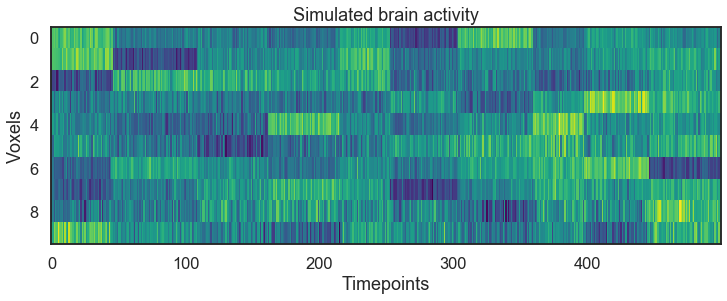

In [7]:
V = 10 # number of voxels
K = 10 # number of events
T = 500 # Time points

# Generate the first dataset
np.random.seed(1)
event_means = np.random.randn(V, K)
event_labels = generate_event_labels(T, K, 0.2)
D = generate_data(V, T, event_labels, event_means, 1/4)

# Check the data. 
f, ax = plt.subplots(1,1, figsize=(12, 4))
ax.imshow(D, interpolation='nearest', cmap='viridis', aspect='auto')
ax.set_ylabel('Voxels')
ax.set_title('Simulated brain activity')
ax.set_xlabel('Timepoints')

Text(0, 0.5, 'TR')

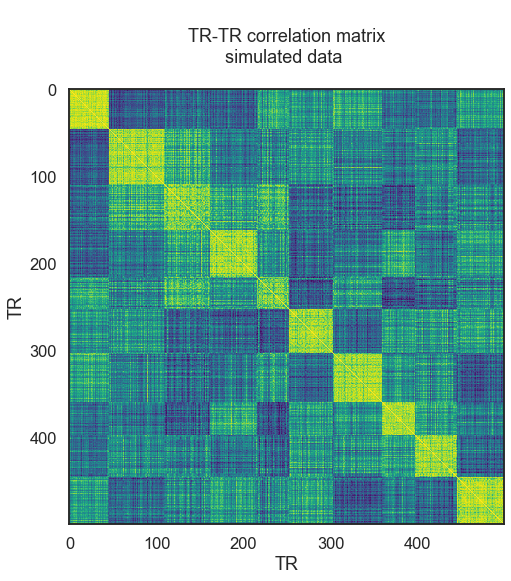

In [8]:
f, ax = plt.subplots(1,1, figsize = (10,8))
ax.imshow(np.corrcoef(D.T), cmap='viridis')
title_text = '''
TR-TR correlation matrix
simulated data 
'''
ax.set_title(title_text)
ax.set_xlabel('TR')
ax.set_ylabel('TR')

In [9]:
# Find the events in this dataset
hmm_sim = brainiak.eventseg.event.EventSegment(K)
hmm_sim.fit(D.T)

EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=10, n_iter=500, split_merge=False,
             split_merge_proposals=1,
             step_var=<function EventSegment._default_var_schedule at 0x11a4bf7b8>)

Text(0.5, 0, 'Voxels')

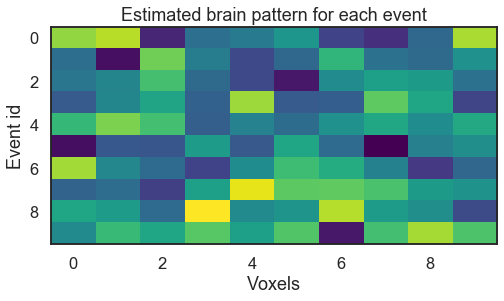

In [10]:
f, ax = plt.subplots(1,1, figsize=(8, 4))

ax.imshow(hmm_sim.event_pat_.T, cmap='viridis', aspect='auto')
ax.set_title('Estimated brain pattern for each event')
ax.set_ylabel('Event id')
ax.set_xlabel('Voxels')

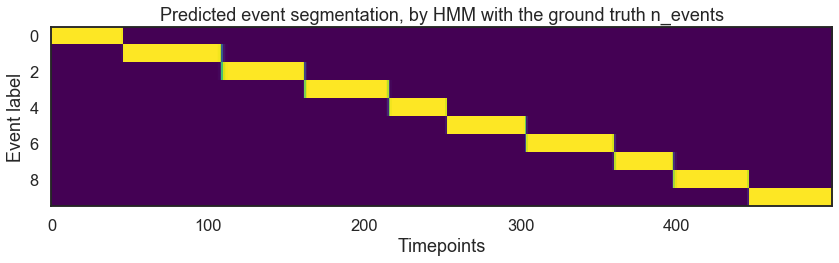

In [11]:
# plot 
f, ax = plt.subplots(1,1, figsize=(12,4))

pred_seg = hmm_sim.segments_[0]
ax.imshow(pred_seg.T, aspect='auto', cmap='viridis')
ax.set_xlabel('Timepoints')
ax.set_ylabel('Event label')
ax.set_title('Predicted event segmentation, by HMM with the ground truth n_events')

f.tight_layout()

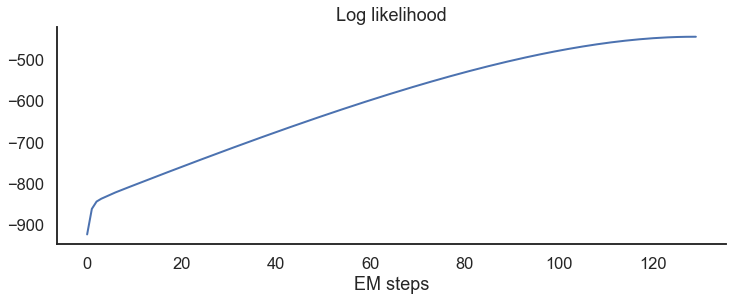

In [12]:
f, ax = plt.subplots(1,1, figsize=(12, 4))

ax.plot(hmm_sim.ll_)
ax.set_title('Log likelihood')
ax.set_xlabel('EM steps')
sns.despine()

In [13]:
def plot_tt_similarity_matrix(ax, data_matrix, bounds, n_TRs, title_text):
    ax.imshow(np.corrcoef(data_matrix.T), cmap='viridis')
    ax.set_title(title_text)
    ax.set_xlabel('TR')
    ax.set_ylabel('TR')
    # plot the boundaries 
    bounds_aug = np.concatenate(([0],bounds,[n_TRs]))
    for i in range(len(bounds_aug)-1):
        rect = patches.Rectangle(
            (bounds_aug[i],bounds_aug[i]),
            bounds_aug[i+1]-bounds_aug[i],
            bounds_aug[i+1]-bounds_aug[i],
            linewidth=2,edgecolor='w',facecolor='none'
        )
        ax.add_patch(rect)

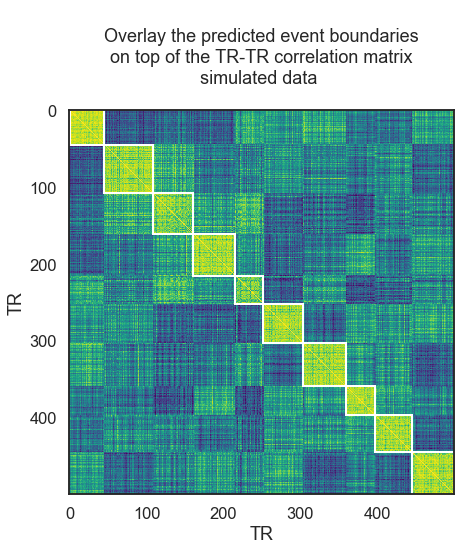

In [14]:
# extract the boundaries 
bounds = np.where(np.diff(np.argmax(pred_seg, axis=1)))[0]

f, ax = plt.subplots(1,1, figsize = (10,8))
title_text = '''
Overlay the predicted event boundaries
on top of the TR-TR correlation matrix
simulated data 
'''
plot_tt_similarity_matrix(ax, D, bounds, T, title_text)
f.tight_layout()